## 0. 구글 드라이브 연결 및 필수 라이브러리 설치 및 로드

### 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 필수 라이브러리 설치 및 로드

In [2]:
#!pip install nltk

In [3]:
#!pip install konlpy

In [4]:
#from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import nltk
import re

In [5]:
#nltk.download()

# 이거 안하면 lookuperror 뜬다.(필요한 것만 지정해서 다운로드 해도되고, all을 사용하여 모두 다운로드 해도 된다.)

In [6]:
# 이후에 데이터 및 파일들을 저장할 경로를 path로 통일하여 따로 저장

path = '/content/gdrive/MyDrive/Colab Notebooks/CUAI 하계프로젝트-NLP/초기 모델링 진행/data/'

***여기 이후부터는 완료된 단계(4. 토큰화, 5. 정수 인코딩 등)로 점프해서 실행시키면 됨!!(노트북을 나누면서 앞부분 삭제함)***

## 6. GPT2 모델링

### 6-1. GPT2 모델링에 필요한 모듈 및 함수 import  

앞선 단계에서 토큰화, 정수 인코딩, 패딩, 워드 임베딩을 수행했으나   
GPT2 모델링에 참고한 책 **"텐서플로 2와 머신러닝으로 시작하는 자연어 처리"**를 보니(p.516) 기존에 한 것과 아예 다른 토크나이저를 사용하기 때문에 모델의 입력 데이터를 구성하는 방식이 다르다고 함  
따라서 책에 있는 코드를 따라가며 GPT2 모델링에 필요한 모듈 및 함수 import하였음

In [7]:
!pip install gluonnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 4.5 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595735 sha256=e7e565fa8717d7f1cbfcdaacf3b8fdcdc0e0d6ad163dbf74c0ebe2eec3b6b38e
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


In [8]:
!pip install mxnet 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 161 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.7 MB/s 
     |████████████████████████████████| 101 kB 14.2 MB/s 
     |████████████████████████████████| 6.6 MB 45.9 MB/s 
     |████████████████████████████████| 596 kB 71.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
# 모델 학습에 필요한 3개의 모듈 import

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from transformers import *
import tensorflow as tf

In [11]:
# 불러온 모델을 활용해 여기서 사용할 모델 클래스를 구현
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [12]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e91d13b30927d5ccee2f9bc3e4a7a7f7aa44152c5008aa3c244bf85d8bffd07e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [13]:
# 구현된 모델 클래스에 학습된 파라미터를 다운로드
import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')
with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

In [14]:
# 학습된 파라미터를 다운로드 받았다면 다음과 같은 경로로 파라미터를 이동시킨 후 모델을 선언
# 경로에는 반드시 config.json과 tf.model.h5 파일이 있어야 함
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

loading configuration file ./gpt_ckpt/config.json
Model config GPT2Config {
  "activation_function": "gelu",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.21.1",
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ./gpt_ckpt/tf_model.h5
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model c

### 6-2. final_data를 train/test로 나눈 후 train 데이터 전처리

In [15]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.7 MB/s 


In [16]:
# 데이터를 불러오기에 앞서 먼저 토크나이저를 생성
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'
tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH, 
                                               mask_token=None, 
                                               sep_token='<unused0>', 
                                               cls_token=None, 
                                               unknown_token='<unk>',  
                                               padding_token='<pad>', 
                                               bos_token='<s>', 
                                               eos_token='</s>')

|스페셜 토큰|역할|
|-------|--------|
| unused0 |SEP 토큰으로 두 개의 문장을 입력할 때 문장을 구분해 주는 토큰으로 활용  
||(자연어 추론과 텍스트 유사도 모델에서 활용 예정)|

In [17]:
# 이제 final_data 로드
# (참고)path 부분은 맨 앞 0장의 마지막 코드에서 경로 지정하였음!

data = pd.read_excel(path + 'final_data.xlsx', engine='openpyxl')

In [18]:
data.tail(3)

,Unnamed: 0,document,label
303472,303472,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
303473,303473,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0
303474,303474,안부전화라도 해주면 좋을 텐데,0


In [19]:
# 책에 train과 test 데이터를 나눴으므로 train_test_split을 이용해 final_data를 분리(랜덤 시드 42로 고정)
X_train, X_test, y_train, y_test = train_test_split(data['document'],data['label'], 
                                                    test_size = 0.2, stratify = data['label'], random_state=42)

In [20]:
# 다시 train과 test끼리 묶어주고 이것을 일단 txt 파일로 저장
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv(path + 'final_train_data.txt', sep = '\t', index = False)
test_data.to_csv(path + 'final_test_data.txt', sep = '\t', index = False)

In [24]:
# 이제 train 데이터로 토크나이저를 활용해 모델에 입력할 데이터를 구성
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
    train_tokenized_text = vocab[tokenizer(train_sent)] 
    # 위 코드 우측 부분이 책에는 clean_text(train_sent)로 되어있었으나 검색해보니
    # clean_text가 불필요한 문자 제거 그런거여서 이미 정제된 상태이므로 그냥 train_sent로 작성함

    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([train_tokenized_text], 
                            maxlen=28, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

#train_data_sents = np.array(train_data_sents, dtype=np.int64)
#train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [25]:
# 원래는 위 코드 마지막에 이 부분이 같이 있었는데 계속 오류나서 따로 떼어옴
# 위 코드에서 maxlen을 특정 숫자(일단 28, 이전 단계에서 길이 28로 패딩한 것이 생각나서)
# 로 하니 np.array로 드디어 변환됨(단, 그때 패딩과 이때 패딩이 동일한 것인지는 확실x)
train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

### 6-3. final_train_data를 모델에 학습시키기

In [26]:
# 모델 학습에 앞서 GPT2 텍스트 분류기를 만들기 위해 TFGPT2Classifier라는 클래스를 정의
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class

        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        gpt_output =outputs[0][:, -1]

        pooled_output = self.dropout(gpt_output)
        logits = self.classifier(pooled_output)

        return logits

In [27]:
# 분류기 모델을 학습하는 방법은 책에 앞서 등장했던 BERT나 GPT1의 학습 방법과 동일하다고 함
# 먼저 분류기 모델을 생성하고 최적화 함수와 손실 함수, 평가에 활용할 정확도 함수를 구성해 model.compile을 실행하면
# 모델을 학습할 준비가 끝남
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

loading configuration file ./gpt_ckpt/config.json
Model config GPT2Config {
  "activation_function": "gelu",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.21.1",
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ./gpt_ckpt/tf_model.h5
All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at

In [28]:
# 아래 코드에서 필요했던 모듈 import
from keras.callbacks import *
import os

In [29]:
# 학습을 진행할 때는 GPU로 학습하는 것을 권장한다고 함(그래서 처음 코드 실행할 때부터 런타임:GPU로 해놓았음)
model_name = 'tf2_gpt2'

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

# 이부분 경로는 일단 그냥 구글드라이브의 data 모아놨던 곳으로 코드 바꿈
checkpoint_path = os.path.join(path, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else: 
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor="val_accuracy", 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
)
history = cls_model.fit(
    train_data_sents, 
    train_data_labels, 
    epochs=2, # 임의로 정함
    batch_size=16, # 임의로 정함 
    callbacks=[earlystop_callback, cp_callback], 
)

/content/gdrive/MyDrive/Colab Notebooks/CUAI 하계프로젝트-NLP/초기 모델링 진행/data/tf2_gpt2 -- Folder already exists 

Epoch 1/2
15174/15174 [==============================] - 1884s 123ms/step - loss: 0.3411 - accuracy: 0.8522
Epoch 2/2
15174/15174 [==============================] - 1871s 123ms/step - loss: 0.2738 - accuracy: 0.8861


위에서 cls_model.fit() 실행 시 각 Epoch 당 약 25분 정도의 시간이 소요됨(런타임: GPU로 설정 기준)  
- 첫 번째 Epoch의 accuracy: 85.22%
- 두 번째 Epoch의 accuracy: 88.61%

In [35]:
# 앞에서 numpy array로 변환 실패해서 오류 뜬게 결국 문제가 됨
# 그 이전 코드에서 maxlen을 특정 숫자로 설정해주니까 드디어 실행됨

# accuracy와 loss를 그래프로 나타내기 위한 함수 정의
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

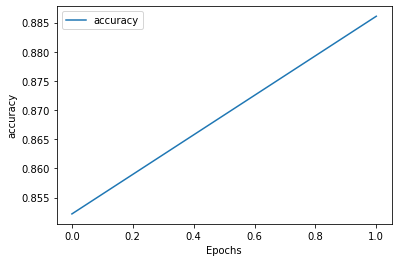

In [36]:
plot_graphs(history, 'accuracy')

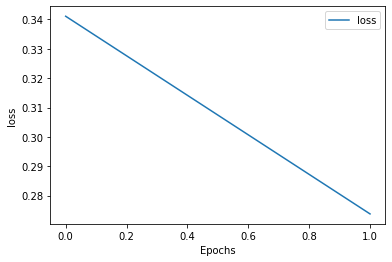

In [37]:
plot_graphs(history, 'loss')

### 6-4. final_test_data로 모델의 성능 테스트하기

In [38]:
# 이제 test 데이터로 테스트를 진행
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
    test_tokenized_text = vocab[tokenizer(test_sent)] 
    # 위 코드 역시 우측 부분이 책에는 clean_text(test_sent)로 되어있었으나 검색해보니
    # clean_text가 불필요한 문자 제거 그런거여서 이미 정제된 상태이므로 그냥 test_sent로 작성함

    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([test_tokenized_text], 
                            maxlen=28, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

In [39]:
test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [41]:
# 다음 코드에서 load_weights에 대응하는 save-weights 코드가 없어 직접 짬
cls_model.save_weights(checkpoint_path)

In [42]:
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)

60/60 [==============================] - 113s 2s/step - loss: 0.2895 - accuracy: 0.8812


test_data에 모델을 테스트해본 결과 accuracy가 88.12%로 꽤 나쁘지 않은 성능을 보였음  
다른 KoBERT나 Bi-LSTM 모델의 결과와 비교해 본 뒤 가장 성능이 좋은 모델을 선택하면 될 것 같음

# END